# identification of how many loops are outliers in cell lines

This is done by estimating the distribution of the counts for each loop across the primary cell samples. After that we can check if the counts from the cell lines are significantly outside that distribution.
This is done because we effectively only have one replicate for the cell lines, whilst the primary samples have a distribution.

In [1]:
import pandas as pd
import numpy as np
import hicstraw 
from multiprocessing import Pool
from functools import partial
import glob
import os
import plotly.express as px
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from pandarallel import pandarallel
import cooler
import cooltools
import pybedtools as pbed
pandarallel.initialize()
from scipy import stats, special
from statsmodels.stats import multitest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.io as pio
import seaborn as sns
os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

plt.rcParams['svg.fonttype'] = 'none'

base_dir = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_cleaned_analysis"

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [10]:
loops_analysed = pd.read_pickle(f"{base_dir}/HiC_analysis/extracting_loop_counts/aggregated_counts/aggregated_normalized_loops_CD4_CD8.pk")
metadata_hic = pd.read_csv(f"{base_dir}/metadata/cleaned_HiC_metadata.csv", index_col = 0)

In [12]:
# melt the loop dataframe and add info about the cell type from the metadata
loops_analysed_melted = pd.melt(loops_analysed, id_vars=['chrA', 'A_start', 'A_end', 'chrB', 'B_start', 'B_end', 'FDR', 'DETECTION_SCALE', 'distance_bin'], 
        value_vars=loops_analysed.columns.difference(['chrA', 'A_start', 'A_end', 'chrB', 'B_start', 'B_end', 'FDR', 'DETECTION_SCALE', 'distance_bin']),
        var_name="sample",value_name="interaction_strength")
df = metadata_hic[["folder_name","cell_type"]].copy()
df = pd.concat([df,pd.DataFrame({"folder_name" : ["all_jurkat","MyLa_all_old_ARIMA"], "cell_type" : ["CD4", "CD8"]})], ignore_index= True)
loops_analysed_melted = loops_analysed_melted.merge(df, left_on = "sample", right_on = "folder_name", how = "left")

Calculate the p-value for how likely the loop is an outlier compare to the rest of the samples.

for each loop, estimate the z-score for each sample, then calculate the p-values from that. 

In [13]:
def retrieve_pvals_CD4(df):
    val_CD4 = df[(df["cell_type"] == "CD4")]
    z_scores_CD4 = stats.zscore(val_CD4["interaction_strength"].values)
    p_values_CD4 = stats.norm.pdf(abs(z_scores_CD4))*2 # two sided
    if val_CD4["interaction_strength"].mean() < 15:
        return pd.Series(dict(zip(val_CD4["sample"], [1]*len(val_CD4["sample"]))))
    return pd.Series(dict(zip(val_CD4["sample"], p_values_CD4)))

def retrieve_pvals_CD8(df):
    val_CD8 = df[(df["cell_type"] == "CD8")]
    z_scores_CD8 = stats.zscore(val_CD8["interaction_strength"].values)
    p_values_CD8 = stats.norm.pdf(abs(z_scores_CD8))*2 # two sided
    if val_CD8["interaction_strength"].mean() < 15:
        return pd.Series(dict(zip(val_CD8["sample"], [1]*len(val_CD8["sample"]))))
    return pd.Series(dict(zip(val_CD8["sample"], p_values_CD8)))

df_CD4 = loops_analysed_melted.groupby(["chrA","A_start","B_start"]).parallel_apply(retrieve_pvals_CD4)
df_CD8 = loops_analysed_melted.groupby(["chrA","A_start","B_start"]).parallel_apply(retrieve_pvals_CD8)

/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools//ipykernel_5509/309570781.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


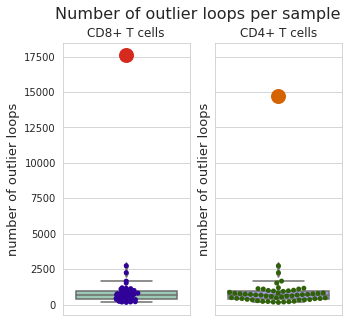

In [17]:
da = df_CD8[df_CD8 < 0.05].count()
da = metadata_hic.merge(da.to_frame(),right_index = True, left_on = "folder_name", how = "right")
da.loc[da["folder_name"] == "MyLa_all_old_ARIMA","cell_type"] = "MyLa"
vals = da[da["cell_type"] != "MyLa"][0]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize = (5,5),sharey=True)
sns.swarmplot(y = vals,ax=axes[0],color="#310299")
sns.boxplot(y = vals,ax=axes[0], color="#94d1b6")
sns.swarmplot(y = da[da["cell_type"] == "MyLa"][0],ax=axes[0],color="#d62a1e", size = 15)


da = df_CD4[df_CD4 < 0.05].count()
da = metadata_hic.merge(da.to_frame(),right_index = True, left_on = "folder_name", how = "right")
da.loc[da["folder_name"] == "all_jurkat","cell_type"] = "Jurkat"
sns.swarmplot(y = vals,ax=axes[1],color="#2f6109")
sns.boxplot(y = vals,ax=axes[1], color="#9e8df0")
sns.swarmplot(y = da[da["cell_type"] == "Jurkat"][0],ax=axes[1],color="#d46300", size = 15)

axes[0].set_title("CD8+ T cells")
axes[1].set_title("CD4+ T cells")
axes[0].set_ylabel("number of outlier loops", fontsize = 13)
axes[1].set_ylabel("number of outlier loops", fontsize = 13)
fig.suptitle("Number of outlier loops per sample", fontsize = 16)
fig.show()
fig.savefig(f"{base_dir}/HiC_analysis/figures/cell_line_outlier_loops.svg")